# Imports

In [9]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import os
import numpy as np

import json

from transformers import MarianTokenizer, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
import collections
from collections import defaultdict

In [3]:
src_lang = "en"
translator = "mbart50"

# Defining plot styles

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kde, gaussian_kde
import matplotlib
from matplotlib import rc

import pandas as pd

In [5]:


plt.rcParams['font.family'] = 'serif'
#plt.rcParams['text.usetex'] = True
plt.rcParams['text.usetex'] = False
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman']

# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.titlesize'] = 26
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18


# Load / Process Data

In [6]:
RECALL=-3
PRECISION=-1

TRANSLATOR="mbart50"
SRC_LANG="en"

In [14]:
def load_old_tokens_dict(tokens_file):
    with open(tokens_file, "r") as f:
        tokens_str = (f.readlines())[0]
    tokens_str = tokens_str.replace("'", "\"")
    tokens_dict = json.loads(tokens_str)
    
    if 'worker' in tokens_dict:
        tokens_dict.pop('worker')
        
    return tokens_dict


def create_tokens_dict(variants_file, translator, src_lang, tgt_lang):
    tokens_dict = defaultdict(dict)
    tokenizer = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
    
    with open(variants_file, 'r') as var_json:
        variants_dict = json.load(var_json)
    
    for prof_gender, variants in variants_dict.items():
        prof, gender = prof_gender.split('-')
        gender = gender.capitalize()
        for v_idx, var in enumerate(variants):
            tokenized = tokenizer(var, add_special_tokens=False)
            num_tokens = len(tokenized['input_ids'])
            
            tokens_dict[f"{prof}-{str(v_idx)}"][gender] = num_tokens
    return tokens_dict


In [15]:
tokens_dict_he = create_tokens_dict("../data/wino_mt/he_variants.json",TRANSLATOR, SRC_LANG, "he")
tokens_dict_de = create_tokens_dict("../data/wino_mt/de_variants.json",TRANSLATOR, SRC_LANG, "de")

In [16]:
with open("../data/male_stereotype","r") as f:
    male_stereotype = f.readlines()
    male_stereotype = {i.strip().lower() for i in male_stereotype}

In [17]:
male_stereotype

{'analyst',
 'carpenter',
 'ceo',
 'chief',
 'construction worker',
 'cook',
 'developer',
 'driver',
 'farmer',
 'guard',
 'janitor',
 'laborer',
 'lawyer',
 'manager',
 'mechanic',
 'mover',
 'physician',
 'salesperson',
 'sheriff',
 'supervisor'}

# Create Plots

In [18]:
def graph_5_delta_g(results_file,tokens_dict,lang):
    with open(results_file, "r") as f:
        lines = f.readlines()
        recalls_str = lines[RECALL]
        recalls_str = recalls_str.replace("'", "\"")
        recalls_dict = json.loads(recalls_str)

        precisions_str = lines[PRECISION]
        precisions_str = precisions_str.replace("'", "\"")
        precisions_dict = json.loads(precisions_str)

    professions = list(tokens_dict.keys())
    delta_t_dict = dict()

    
    for p in professions:
        delta_t_dict[p] = tokens_dict[p]['Male'] - tokens_dict[p]['Female']
    delta_t_dict = dict(sorted(delta_t_dict.items(), key=lambda item: item[1]))


    x = []
    y = []
    
    data = pd.DataFrame({"Delta T": [], "Delta G": [], "M F1": [], "F F1": [], "M T": [], "F T": []})

    for prof, delta_t in delta_t_dict.items():
        prof = prof.lower()
        if prof in recalls_dict and prof in precisions_dict:
            r_m,r_f=recalls_dict[prof]['male_recall'],recalls_dict[prof]['female_recall']
            p_m,p_f=precisions_dict[prof]['male_precision'],precisions_dict[prof]['female_precision']
            if r_m ==0 and p_m == 0:
                male_f1 = 0
            else:
                male_f1= 2 * (r_m*p_m)/(r_m+p_m)
    
            if r_f ==0 and p_f == 0:
                female_f1 = 0
            else:
                female_f1= 2 * (r_f*p_f)/(r_f+p_f)
                
            data = data.append({"Delta T": delta_t, "Delta G": male_f1 - female_f1,
                                "M F1": male_f1, "F F1": female_f1,
                                "M T": tokens_dict[prof]['Male'], "F T": tokens_dict[prof]['Female']},
                               ignore_index=True)


    f, ax = plt.subplots(figsize=(7, 6))

    sns.boxplot(
        data=data, x="Delta T", y="Delta G",
        orient="v",
        notch=False, showcaps=False, showmeans=True,
        boxprops={"facecolor": (.4, .6, .8, .5)},
        medianprops={"color": "coral"})
    sns.stripplot(x="Delta T", y="Delta G", data=data,
              size=4, color=".3", linewidth=0)
    
#     z = np.polyfit(data['Delta T'], data['Delta G'], 1)
#     p = np.poly1d(z)
#     ax.plot(data['Delta T'] + len(data['Delta T'].unique())- 1, p(data['Delta T']), "r--")

    # Tweak the visual presentation
    ax.yaxis.grid(True)
    sns.despine(trim=False)
    
    plt.tight_layout()
    plt.savefig(f'../graphs/graph_5_{lang}_delta_g_mbert.pdf')
    plt.show()
    
    print("correlation")
    print(data.corr())
    
    tidy = data.melt(value_vars=['M F1','F F1'], id_vars=['M T'], value_name='F1',var_name='gender')
    print(tidy)
    
    sns.catplot(x="M T", y='F1',
        data=tidy, kind="bar", hue='gender', 
        palette=sns.color_palette(['lightblue', 'brown']),
        height=4.5, aspect=1.8)


/tmp/ipykernel_24607/2542888689.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Delta T": delta_t, "Delta G": male_f1 - female_f1,
/tmp/ipykernel_24607/2542888689.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Delta T": delta_t, "Delta G": male_f1 - female_f1,
/tmp/ipykernel_24607/2542888689.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Delta T": delta_t, "Delta G": male_f1 - female_f1,
/tmp/ipykernel_24607/2542888689.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Delta T": delta_t, "Delta G": male_f1 - female_f1,
/tmp/ipykernel_2

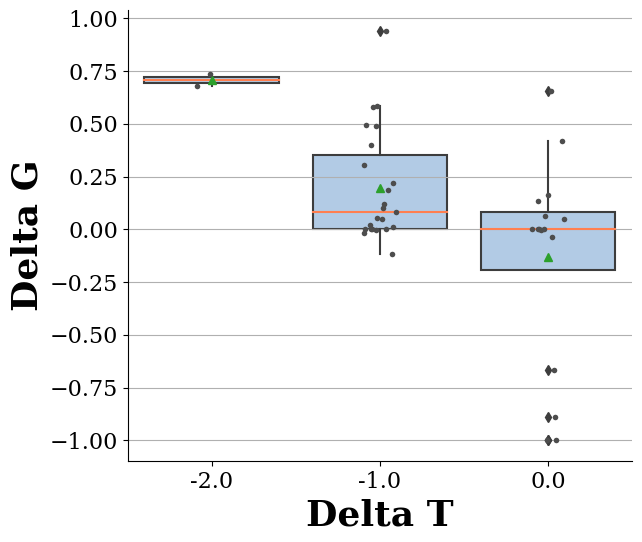

correlation
          Delta T   Delta G      M F1      F F1       M T       F T
Delta T  1.000000 -0.502313 -0.277014  0.381269  0.527246 -0.125849
Delta G -0.502313  1.000000  0.568096 -0.745568 -0.246695  0.084402
M F1    -0.277014  0.568096  1.000000  0.124892 -0.420465 -0.285515
F F1     0.381269 -0.745568  0.124892  1.000000 -0.043071 -0.332965
M T      0.527246 -0.246695 -0.420465 -0.043071  1.000000  0.776604
F T     -0.125849  0.084402 -0.285515 -0.332965  0.776604  1.000000
    M T gender        F1
0   1.0   M F1  0.735294
1   1.0   M F1  0.677419
2   1.0   M F1  0.821053
3   1.0   M F1  0.829787
4   1.0   M F1  0.808081
..  ...    ...       ...
77  3.0   F F1  0.411765
78  2.0   F F1  1.000000
79  2.0   F F1  0.941176
80  3.0   F F1  1.000000
81  2.0   F F1  1.000000

[82 rows x 3 columns]


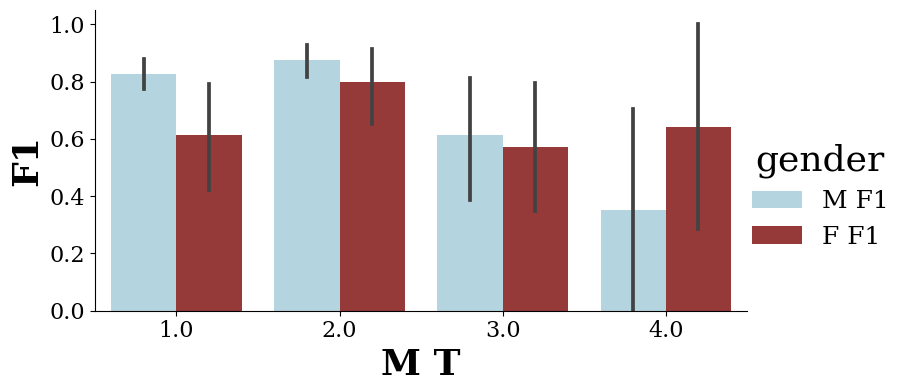

In [28]:
graph_5_delta_g("../data/de_results_mbart.txt", tokens_dict_de,"German")

/tmp/ipykernel_24607/2542888689.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Delta T": delta_t, "Delta G": male_f1 - female_f1,
/tmp/ipykernel_24607/2542888689.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Delta T": delta_t, "Delta G": male_f1 - female_f1,
/tmp/ipykernel_24607/2542888689.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Delta T": delta_t, "Delta G": male_f1 - female_f1,
/tmp/ipykernel_24607/2542888689.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Delta T": delta_t, "Delta G": male_f1 - female_f1,
/tmp/ipykernel_2

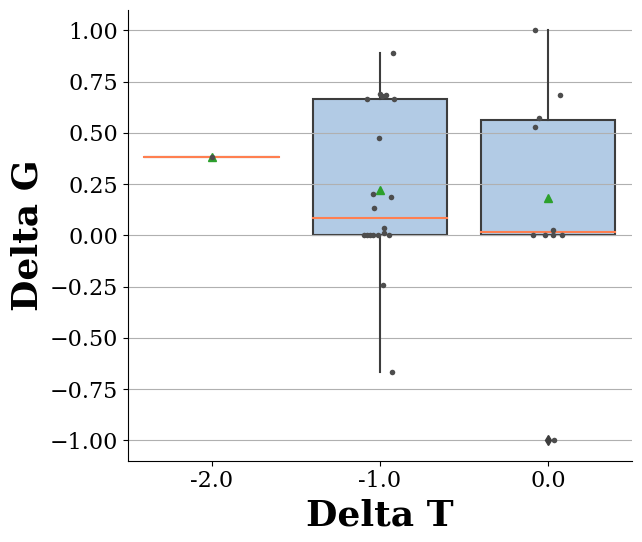

correlation
          Delta T   Delta G      M F1      F F1       M T       F T
Delta T  1.000000 -0.070572  0.034638  0.092046  0.323732 -0.273488
Delta G -0.070572  1.000000  0.313665 -0.822934 -0.038498  0.003390
M F1     0.034638  0.313665  1.000000  0.281340  0.069051  0.049326
F F1     0.092046 -0.822934  0.281340  1.000000  0.080222  0.026088
M T      0.323732 -0.038498  0.069051  0.080222  1.000000  0.821540
F T     -0.273488  0.003390  0.049326  0.026088  0.821540  1.000000
    M T gender        F1
0   1.0   M F1  0.714286
1   2.0   M F1  0.680412
2   2.0   M F1  0.727273
3   2.0   M F1  0.965517
4   1.0   M F1  0.888889
..  ...    ...       ...
57  2.0   F F1  1.000000
58  1.0   F F1  0.956522
59  2.0   F F1  1.000000
60  3.0   F F1  1.000000
61  4.0   F F1  1.000000

[62 rows x 3 columns]


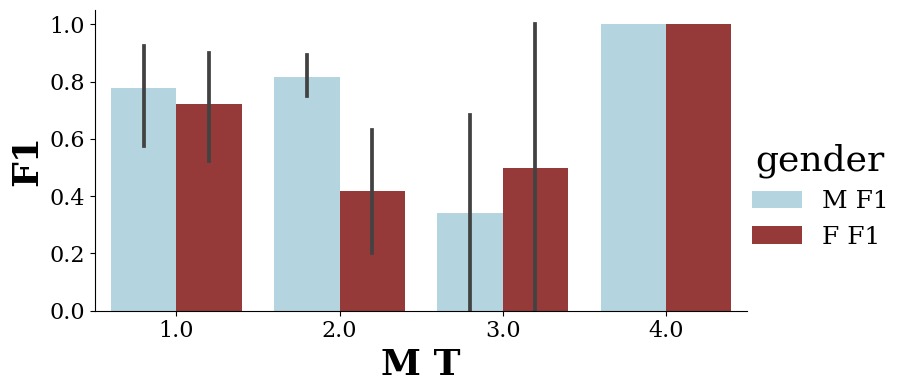

In [29]:
graph_5_delta_g("../data/he_results_mbart.txt", tokens_dict_he,"Hebrew")

In [30]:
def graph_5_delta_s(results_file,tokens_dict,lang, male_stereotype):
    with open(results_file, "r") as f:
        lines = f.readlines()
        recalls_str = lines[RECALL]
        recalls_str = recalls_str.replace("'", "\"")
        recalls_dict = json.loads(recalls_str)

        precisions_str = lines[PRECISION]
        precisions_str = precisions_str.replace("'", "\"")
        precisions_dict = json.loads(precisions_str)

    professions = list(tokens_dict.keys())
    delta_t_dict = dict()
    
    for p in professions:
        if p.split('-')[0] in male_stereotype:
            delta_t_dict[p] = tokens_dict[p]['Male'] - tokens_dict[p]['Female']
        else:
            delta_t_dict[p] = tokens_dict[p]['Female'] - tokens_dict[p]['Male']
    delta_t_dict = dict(sorted(delta_t_dict.items(), key=lambda item: item[1]))



    data = pd.DataFrame({"Delta T": [], "Delta G": [], "P F1": [], "A F1": [], "P T": [], "A T": []})

    for prof, delta_t in delta_t_dict.items():
        prof = prof.lower()
        if prof in recalls_dict and prof in precisions_dict:
            r_m,r_f=recalls_dict[prof]['male_recall'],recalls_dict[prof]['female_recall']
            p_m,p_f=precisions_dict[prof]['male_precision'],precisions_dict[prof]['female_precision']
            if r_m ==0 and p_m == 0:
                male_f1 = 0
            else:
                male_f1= 2 * (r_m*p_m)/(r_m+p_m)
    
            if r_f ==0 and p_f == 0:
                female_f1 = 0
            else:
                female_f1= 2 * (r_f*p_f)/(r_f+p_f)
            
            if prof.split('-')[0] in male_stereotype:
                # data = data.append({"Delta T": delta_t, "Delta S": male_f1 - female_f1}, ignore_index=True)
                data = data.append({"Delta T": delta_t, "Delta S": male_f1 - female_f1,
                    "P F1": male_f1, "A F1": female_f1,
                    "P T": tokens_dict[prof]['Male'], "A T": tokens_dict[prof]['Female']},
                   ignore_index=True)
            else:
                # data = data.append({"Delta T": delta_t, "Delta S": female_f1 - male_f1}, ignore_index=True)
                data = data.append({"Delta T": delta_t, "Delta S": female_f1 - male_f1,
                    "P F1": female_f1, "A F1": male_f1,
                    "P T": tokens_dict[prof]['Female'], "A T": tokens_dict[prof]['Male']},
                   ignore_index=True)


    f, ax = plt.subplots(figsize=(7, 6))

    sns.boxplot(
        data=data, x="Delta T", y="Delta S",
        orient="v",
        notch=False, showcaps=False,showmeans=True,
        boxprops={"facecolor": (.6, .8, .4, .5)},
        medianprops={"color": "coral"})
    sns.stripplot(x="Delta T", y="Delta S", data=data,
              size=4, color=".3", linewidth=0)
    
#     z = np.polyfit(data['Delta T'], data['Delta G'], 1)
#     p = np.poly1d(z)
#     ax.plot(data['Delta T'] + len(data['Delta T'].unique())- 1, p(data['Delta T']), "r--")

    # Tweak the visual presentation
    ax.yaxis.grid(True)
    sns.despine(trim=False)
    
    plt.tight_layout()
    plt.savefig(f'../graphs/graph_5_{lang}_delta_s_mbert.pdf')
    plt.show()
    
    print("correlation")
    print(data.corr())
    
    tidy = data.melt(value_vars=['P F1','A F1'], id_vars=['P T'], value_name='F1',var_name='stereotpe')
    print(tidy)
    
    sns.catplot(x="P T", y='F1',
        data=tidy, kind="bar", hue='stereotpe', 
        palette=sns.color_palette(['mediumaquamarine', 'darkorange']),
        height=4.5, aspect=1.8)


/tmp/ipykernel_24607/3512795360.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Delta T": delta_t, "Delta S": male_f1 - female_f1,
/tmp/ipykernel_24607/3512795360.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Delta T": delta_t, "Delta S": male_f1 - female_f1,
/tmp/ipykernel_24607/3512795360.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Delta T": delta_t, "Delta S": male_f1 - female_f1,
/tmp/ipykernel_24607/3512795360.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Delta T": delta_t, "Delta S": male_f1 - female_f1,
/tmp/ipykernel_2

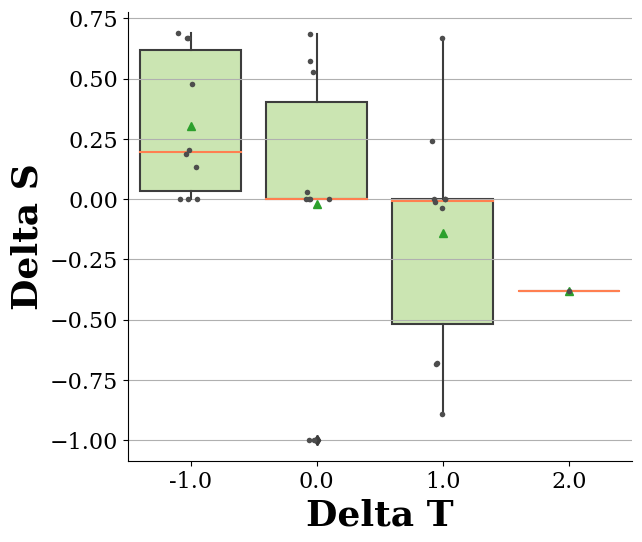

correlation
          Delta T  Delta G      P F1      A F1       P T       A T   Delta S
Delta T  1.000000      NaN -0.270026  0.259476  0.384682 -0.543029 -0.403504
Delta G       NaN      NaN       NaN       NaN       NaN       NaN       NaN
P F1    -0.270026      NaN  1.000000  0.145667 -0.076463  0.171568  0.596925
A F1     0.259476      NaN  0.145667  1.000000  0.172682 -0.074615 -0.706787
P T      0.384682      NaN -0.076463  0.172682  1.000000  0.566204 -0.194710
A T     -0.543029      NaN  0.171568 -0.074615  0.566204  1.000000  0.183189
Delta S -0.403504      NaN  0.596925 -0.706787 -0.194710  0.183189  1.000000
    P T stereotpe        F1
0   2.0      P F1  0.727273
1   1.0      P F1  0.771429
2   2.0      P F1  0.785047
3   2.0      P F1  0.816901
4   2.0      P F1  0.666667
..  ...       ...       ...
57  2.0      A F1  0.000000
58  2.0      A F1  0.571429
59  5.0      A F1  1.000000
60  3.0      A F1  1.000000
61  3.0      A F1  0.714286

[62 rows x 3 columns]


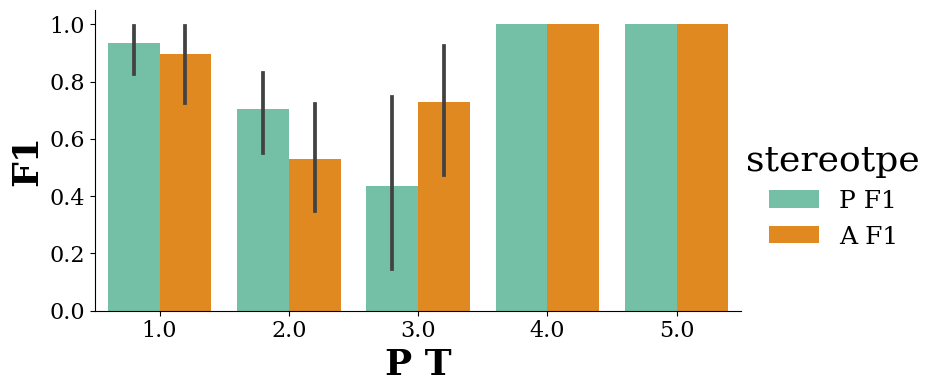

In [32]:
graph_5_delta_s("../data/he_results_mbart.txt", tokens_dict_he,"Hebrew", male_stereotype)

/tmp/ipykernel_24607/3512795360.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Delta T": delta_t, "Delta S": male_f1 - female_f1,
/tmp/ipykernel_24607/3512795360.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Delta T": delta_t, "Delta S": male_f1 - female_f1,
/tmp/ipykernel_24607/3512795360.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Delta T": delta_t, "Delta S": male_f1 - female_f1,
/tmp/ipykernel_24607/3512795360.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Delta T": delta_t, "Delta S": male_f1 - female_f1,
/tmp/ipykernel_2

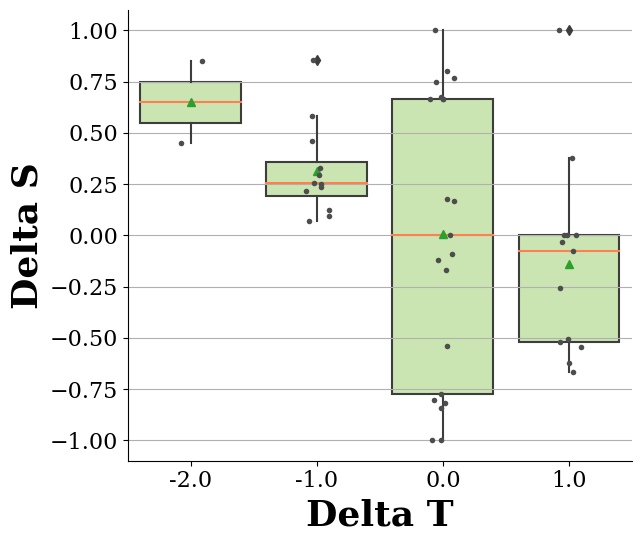

correlation
          Delta T  Delta G      P F1      A F1       P T       A T   Delta S
Delta T  1.000000      NaN -0.250799  0.334804  0.519889 -0.434119 -0.361976
Delta G       NaN      NaN       NaN       NaN       NaN       NaN       NaN
P F1    -0.250799      NaN  1.000000 -0.320632 -0.336500 -0.108486  0.798157
A F1     0.334804      NaN -0.320632  1.000000  0.019053 -0.308812 -0.826557
P T      0.519889      NaN -0.336500  0.019053  1.000000  0.543848 -0.212076
A T     -0.434119      NaN -0.108486 -0.308812  0.543848  1.000000  0.131949
Delta S -0.361976      NaN  0.798157 -0.826557 -0.212076  0.131949  1.000000
    P T stereotpe        F1
0   1.0      P F1  0.850000
1   1.0      P F1  0.705882
2   1.0      P F1  0.678261
3   1.0      P F1  0.747664
4   1.0      P F1  0.727273
..  ...       ...       ...
91  3.0      A F1  1.000000
92  4.0      A F1  0.666667
93  4.0      A F1  0.727273
94  3.0      A F1  0.326531
95  2.0      A F1  0.689655

[96 rows x 3 columns]


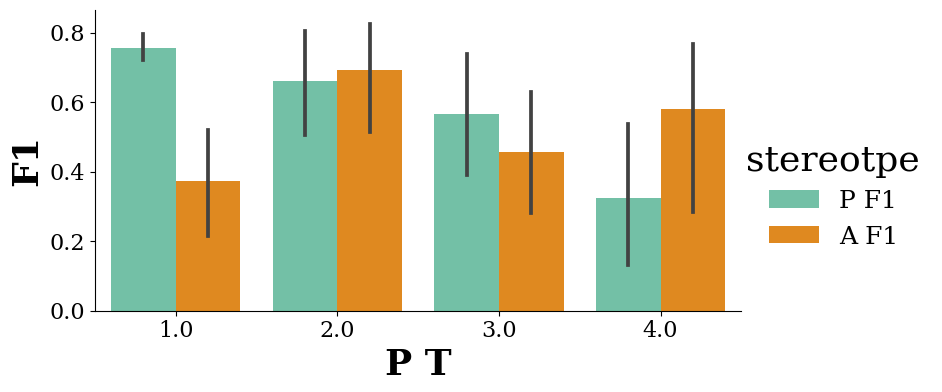

In [33]:
graph_5_delta_s("../data/de_results.txt", tokens_dict_de,"German", male_stereotype)